# LightGBM
LightGBMを用いて、銀行の顧客ターゲティングの学習・推論を行うサンプルコードです。こちらのコードをベースに、自分のアイディアをコードに盛り込み、改善を重ねてみてください。

公式ドキュメント
- https://lightgbm.readthedocs.io/en/stable/

参考Notebook
- https://github.com/microsoft/LightGBM/blob/90786966ae7e75850043b38a12b1775176463435/examples/python-guide/simple_example.py

LightGBMの理論を知りたい人向け
- LightGBMで用いられている手法「勾配ブースティング」の説明
  - https://xgboost.readthedocs.io/en/latest/tutorials/model.html
- LightGBMの論文
  - https://proceedings.neurips.cc/paper_files/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf

## LightGBMとは

テーブルデータに対する推論を行う場合によく使われる、勾配ブースティングの一種です。下記のような特徴があります。
- 欠損値をそのまま扱える。
- 特徴量に対するスケーリングが不要である。
- 特徴量重要度が確認できる。
- 大きいデータに対しても、比較的高速に動作する。

## 勾配ブースティング とは

- 複数個の決定木を直列に繋げ、学習する手法である。
- 一つ前に学習した決定木の誤差を、新しい分類器が小さくするよう学習する。

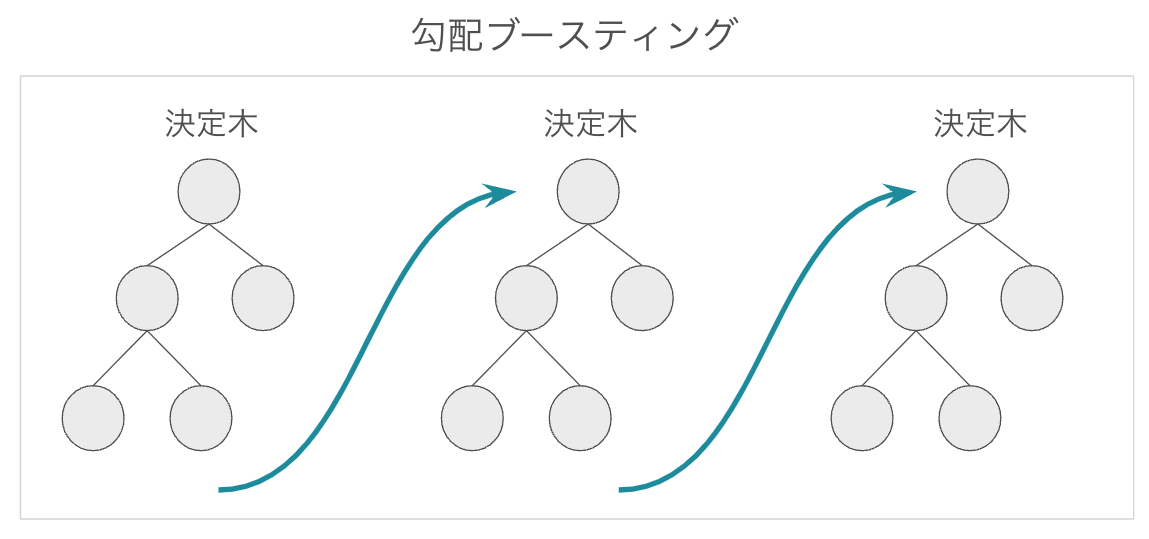

## Import

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, train_test_split

import lightgbm as lgb

Pythonのバージョン

In [22]:
!python --version

Python 3.11.7


lightgbmのバージョン

In [26]:
lgb.__version__

'4.5.0'

## 設定

In [31]:
# Path
input_path = "../input_data/"

## データの読み込み

In [34]:
train = pd.read_csv(input_path + "bank/train.csv")
test = pd.read_csv(input_path + "bank/test.csv")

## データの加工

In [36]:
# LightGBMにカテゴリ変数として認識させる列名を指定
categorical_features = [
    "job",
    "marital",
    "education",
    "default",
    "housing",
    "loan",
    "contact",
    "month",
    "poutcome"
]

# カテゴリ変数として指定した列について、pandas.DataFrameのデータ型を"category"に変更
# LightGBMはpandas.DataFrameのデータ型が"category"の列をカテゴリ変数として扱う
for feat_name in categorical_features:
    train[feat_name] = train[feat_name].astype("category")
    test[feat_name] = test[feat_name].astype("category")

## Cross Validationによる学習

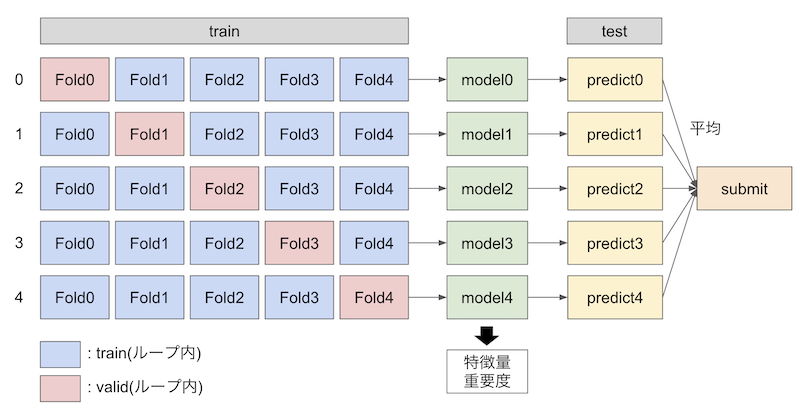


これから行うことを上図で示しています。
- forループ内にて、foldごとにtrainとvalidを分け、LightGBMの学習を行いmodelを保存
- modelごとにtestデータに対する推論を行い、平均を計算し、一つの推論結果とする
- modelから特徴量重要度を計算
- 推論結果から、submitファイルを生成

In [39]:
# Cross Validationの際に用いるfold(分割する際のグループ番号)を追加
FOLD_NUM = 5

kf = KFold(n_splits=FOLD_NUM, shuffle=True, random_state=42)
for fold, (_, v_idx) in enumerate(kf.split(train)):
    train.loc[v_idx, "fold"] = fold
    
train["fold"] = train["fold"].astype(int)

In [41]:
# foldの確認
train["fold"].value_counts()

fold
1    5426
0    5426
2    5426
3    5425
4    5425
Name: count, dtype: int64

In [43]:
# 説明変数として用いるcolumnを指定
use_columns = [
    "age", 
    "job",
    "marital",
    "education",
    "default",
    "balance",
    "housing",
    "loan",
    "contact",
    "day",
    "month",
    "duration",
    "campaign",
    "pdays",
    "previous",
    "poutcome"
]

In [45]:
# LightGBMで用いるパラメーターを指定
# ref: https://lightgbm.readthedocs.io/en/v3.3.5/Parameters.html
params = {
    "objective": "binary", # 実行するタスクの種類、今回は分類問題のためbinary, 回帰問題の場合はregression
    "learning_rate": 0.05, # 1回のiterationで学習を進める割合、大きいと学習が早く終わる。小さいと学習は長いが高精度になりやすい。
    "bagging_freq": 5, # 指定した回数ごとにbaggingを行う
    "feature_fraction": 0.9, # 1回のiterationで利用する特徴量(列方向)の割合
    "bagging_fraction": 0.8, # 1回のiterationで利用するデータ(行方向)の割合
    "verbose": 0, # 出力するログレベルの変更、0はError(Warning)以上を表示
    "seed": 42, # ランダムシードの固定
}

In [47]:
# 学習データ全体に対する推論結果を保存するobjectを作成
oof = np.zeros((len(train)))

# テストデータに対する推論、特徴量重要度(後述)を計算するために、モデルを保存するobjectを作成
models = []

# Cross Validationによる学習の実施
for fold in range(FOLD_NUM):
    print(f"Start fold{fold}")
    
    # foldごとにtrainとvalidに分ける
    train_fold = train[train["fold"] != fold] 
    valid_fold = train[train["fold"] == fold]
    
    # X(説明変数)とy(目的変数)に分ける
    X_train = train_fold.drop("y", axis=1)
    X_valid = valid_fold.drop("y", axis=1)
    y_train = train_fold[["y"]]
    y_valid = valid_fold[["y"]]
    
    # 利用する説明変数に限定する
    X_train = X_train[use_columns]
    X_valid = X_valid[use_columns]
    
    # LightGBMが認識可能な形にデータセットを変換
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    
    # モデルの学習
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=10000, # 学習のiteration回数
        valid_sets=lgb_eval,
        callbacks=[lgb.early_stopping(stopping_rounds=100)] # Early stopingの回数、binary_loglossが改善しないiterationが100回続いたら学習を止める
    )
    
    # モデルを保存
    models.append(model)
    
    # validデータに対する推論
    y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration)
    
    # validデータに対する推論の性能を計算
    score = roc_auc_score(y_valid, y_valid_pred)
    print(f'fold {fold} AUC: {score}')
    
    # oofに推論結果を保存
    valid_idx = valid_fold.index
    oof[valid_idx] = y_valid_pred

Start fold0
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.189275
fold 0 AUC: 0.9371155046457317
Start fold1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 0.190382
fold 1 AUC: 0.9375425494254126
Start fold2
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.197375
fold 2 AUC: 0.9327560456630068
Start fold3
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[175]	valid_0's binary_logloss: 0.215706
fold 3 AUC: 0.9245744968256112
Start fold4
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[183]	valid_0's binary_logloss: 0.201354
fold 4 AUC: 0.9347945137439768


In [48]:
# oofから学習データ全体に対する推論結果の性能を確認
oof_score = roc_auc_score(train["y"].values, oof)
print(f"{oof_score=:.4f}")

oof_score=0.9330


## 特徴量重要度の計算
学習の際に、特徴量がどの程度有効だったかを示す値

In [50]:
# 特徴量重要度を列にもつDataFrameを作成
feature_importances = [model.feature_importance(importance_type='gain') for model in models]
feature_importances_df = pd.DataFrame(feature_importances, columns=use_columns)

# 表示する順番を指定、特徴量重要度の平均が大きい順に並ぶよう計算
order = feature_importances_df.mean().sort_values(ascending=False).index.tolist()

In [ ]:
# 表示
# fold毎の特徴量重要度のばらつきを見るために、箱ひげ図を利用
sns.boxplot(data=feature_importances_df, orient='h', order=order);

## テストデータに対する推論

In [ ]:
# テストデータに対する推論結果を保存するobjectを作成
test_preds_all = np.zeros((len(test)))

In [ ]:
# 各foldの推論結果の平均を計算
for model in models:
    test_preds_all += model.predict(test[use_columns], num_iteration=model.best_iteration) / FOLD_NUM

## Submitファイルの作成

In [ ]:
submit= pd.DataFrame(
    {
        "id" : test["id"],
        "y" : test_preds_all
    }
)

In [ ]:
submit

In [ ]:
# 出力
submit.to_csv("../submit/submit_lgbm_sample.csv", header=False, index=False)

submitすると、0.9406864というscoreが得られました。(環境により多少の変動はあります。)これはoofのスコアである0.9330と大きくは乖離しません。

そのため、テストに対する推論に大きなバグがないことが分かります。